## Introduction

For this project I will be tracking and predicting covid 19 infections, deaths, and vaccinations world wide. To begin I load in relevant libraries and the dataset.

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import plotly.express as px
import plotly.graph_objects as go

from pmdarima.arima import auto_arima

from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
from utility_functions import run_diagnostics, plot_test_predictions, plot_forecast

In [4]:
data = pd.read_csv('owid-covid-data.csv')
data.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          1.0        1.0   
1      AFG      Asia  Afghanistan  2020-02-25          1.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          1.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          1.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          1.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
0        1803.987              NaN                597.029   
1        1803.987              NaN                597.029   
2        1803.987              NaN                597.029   
3        1803.987              NaN                597.029   
4        1803.987              NaN                597.029   

   diabetes_prevalence  female_smokers  male_smokers  handwashing_facilities  \
0                 9.59             NaN           NaN                  37.746   
1                 9.59             NaN           NaN                  37.746   
2                 9.59             NaN           NaN                  37.746   
3                 9.59             NaN           NaN                  37.746   
4                 9.59             NaN           NaN                  37.746   

   hospital_beds_per_thousand  life_expectancy  human_development_index  
0                         0.5            64.83                    0.511  
1                         0.5            64.83                    0.511  
2                         0.5            64.83                    0.511  
3                         0.5            64.83                    0.511  
4                         0.5            64.83                    0.511  

[5 rows x 59 columns]

In [5]:
data.shape

(70444, 59)

## Data Cleaning

To begin, I am going to pull out the data pertaining to the United States, and the summary of covid data worldwide.

In [6]:
us_data = data[data.location == 'United States']
us_data.head()

iso_code      continent       location        date  total_cases  \
66764      USA  North America  United States  2020-01-22          1.0   
66765      USA  North America  United States  2020-01-23          1.0   
66766      USA  North America  United States  2020-01-24          2.0   
66767      USA  North America  United States  2020-01-25          2.0   
66768      USA  North America  United States  2020-01-26          5.0   

       new_cases  new_cases_smoothed  total_deaths  new_deaths  \
66764        NaN                 NaN           NaN         NaN   
66765        0.0                 NaN           NaN         NaN   
66766        1.0                 NaN           NaN         NaN   
66767        0.0                 NaN           NaN         NaN   
66768        3.0                 NaN           NaN         NaN   

       new_deaths_smoothed  ...  gdp_per_capita  extreme_poverty  \
66764                  NaN  ...       54225.446              1.2   
66765                  NaN  ...       54225.446              1.2   
66766                  NaN  ...       54225.446              1.2   
66767                  NaN  ...       54225.446              1.2   
66768                  NaN  ...       54225.446              1.2   

       cardiovasc_death_rate  diabetes_prevalence  female_smokers  \
66764                151.089                10.79            19.1   
66765                151.089                10.79            19.1   
66766                151.089                10.79            19.1   
66767                151.089                10.79            19.1   
66768                151.089                10.79            19.1   

       male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
66764          24.6                     NaN                        2.77   
66765          24.6                     NaN                        2.77   
66766          24.6                     NaN                        2.77   
66767          24.6                     NaN                        2.77   
66768          24.6                     NaN                        2.77   

       life_expectancy  human_development_index  
66764            78.86                    0.926  
66765            78.86                    0.926  
66766            78.86                    0.926  
66767            78.86                    0.926  
66768            78.86                    0.926  

[5 rows x 59 columns]

In [7]:
world_data = data[data.iso_code == 'OWID_WRL']
world_data.head()

iso_code continent location        date  total_cases  new_cases  \
69049  OWID_WRL       NaN    World  2020-01-22        557.0        0.0   
69050  OWID_WRL       NaN    World  2020-01-23        655.0       98.0   
69051  OWID_WRL       NaN    World  2020-01-24        941.0      286.0   
69052  OWID_WRL       NaN    World  2020-01-25       1433.0      492.0   
69053  OWID_WRL       NaN    World  2020-01-26       2118.0      685.0   

       new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
69049                 NaN          17.0         0.0                  NaN  ...   
69050                 NaN          18.0         1.0                  NaN  ...   
69051                 NaN          26.0         8.0                  NaN  ...   
69052                 NaN          42.0        16.0                  NaN  ...   
69053                 NaN          56.0        14.0                  NaN  ...   

       gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
69049       15469.207             10.0                 233.07   
69050       15469.207             10.0                 233.07   
69051       15469.207             10.0                 233.07   
69052       15469.207             10.0                 233.07   
69053       15469.207             10.0                 233.07   

       diabetes_prevalence  female_smokers  male_smokers  \
69049                 8.51           6.434        34.635   
69050                 8.51           6.434        34.635   
69051                 8.51           6.434        34.635   
69052                 8.51           6.434        34.635   
69053                 8.51           6.434        34.635   

       handwashing_facilities  hospital_beds_per_thousand  life_expectancy  \
69049                   60.13                       2.705            72.58   
69050                   60.13                       2.705            72.58   
69051                   60.13                       2.705            72.58   
69052                   60.13                       2.705            72.58   
69053                   60.13                       2.705            72.58   

       human_development_index  
69049                    0.737  
69050                    0.737  
69051                    0.737  
69052                    0.737  
69053                    0.737  

[5 rows x 59 columns]

Now I will check for missing values in the us_data dataframe.

In [8]:
us_data.isna().sum()

iso_code                                   0
continent                                  0
location                                   0
date                                       0
total_cases                                0
new_cases                                  1
new_cases_smoothed                         6
total_deaths                              38
new_deaths                                38
new_deaths_smoothed                        6
total_cases_per_million                    0
new_cases_per_million                      1
new_cases_smoothed_per_million             6
total_deaths_per_million                  38
new_deaths_per_million                    38
new_deaths_smoothed_per_million            6
reproduction_rate                         44
icu_patients                              67
icu_patients_per_million                  67
hosp_patients                             58
hosp_patients_per_million                 58
weekly_icu_admissions                    347
weekly_icu

For now, we will need to look at the new_cases, total_deaths, new_deaths, new_cases_per_million, total_deaths_per_million, and new_deaths_per_million. I imagine that most of theses null values will be able to be substituted for zero, but I will take a closer look to make sure.

In [9]:
us_data[us_data.new_cases.isna()]

iso_code      continent       location        date  total_cases  \
66764      USA  North America  United States  2020-01-22          1.0   

       new_cases  new_cases_smoothed  total_deaths  new_deaths  \
66764        NaN                 NaN           NaN         NaN   

       new_deaths_smoothed  ...  gdp_per_capita  extreme_poverty  \
66764                  NaN  ...       54225.446              1.2   

       cardiovasc_death_rate  diabetes_prevalence  female_smokers  \
66764                151.089                10.79            19.1   

       male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
66764          24.6                     NaN                        2.77   

       life_expectancy  human_development_index  
66764            78.86                    0.926  

[1 rows x 59 columns]

The first data point in the us_data dataframe is the only null value for new cases. It also contains the only null value for new_cases_per_million. At this point there were no new cases. We can easily substitute a zero for both of these values.

In [10]:
us_data[us_data.total_deaths.isna()]

iso_code      continent       location        date  total_cases  \
66764      USA  North America  United States  2020-01-22          1.0   
66765      USA  North America  United States  2020-01-23          1.0   
66766      USA  North America  United States  2020-01-24          2.0   
66767      USA  North America  United States  2020-01-25          2.0   
66768      USA  North America  United States  2020-01-26          5.0   
66769      USA  North America  United States  2020-01-27          5.0   
66770      USA  North America  United States  2020-01-28          5.0   
66771      USA  North America  United States  2020-01-29          6.0   
66772      USA  North America  United States  2020-01-30          6.0   
66773      USA  North America  United States  2020-01-31          8.0   
66774      USA  North America  United States  2020-02-01          8.0   
66775      USA  North America  United States  2020-02-02          8.0   
66776      USA  North America  United States  2020-02-03         11.0   
66777      USA  North America  United States  2020-02-04         11.0   
66778      USA  North America  United States  2020-02-05         11.0   
66779      USA  North America  United States  2020-02-06         12.0   
66780      USA  North America  United States  2020-02-07         12.0   
66781      USA  North America  United States  2020-02-08         12.0   
66782      USA  North America  United States  2020-02-09         12.0   
66783      USA  North America  United States  2020-02-10         12.0   
66784      USA  North America  United States  2020-02-11         13.0   
66785      USA  North America  United States  2020-02-12         13.0   
66786      USA  North America  United States  2020-02-13         14.0   
66787      USA  North America  United States  2020-02-14         14.0   
66788      USA  North America  United States  2020-02-15         14.0   
66789      USA  North America  United States  2020-02-16         14.0   
66790      USA  North America  United States  2020-02-17         14.0   
66791      USA  North America  United States  2020-02-18         14.0   
66792      USA  North America  United States  2020-02-19         14.0   
66793      USA  North America  United States  2020-02-20         14.0   
66794      USA  North America  United States  2020-02-21         16.0   
66795      USA  North America  United States  2020-02-22         16.0   
66796      USA  North America  United States  2020-02-23         16.0   
66797      USA  North America  United States  2020-02-24         16.0   
66798      USA  North America  United States  2020-02-25         16.0   
66799      USA  North America  United States  2020-02-26         16.0   
66800      USA  North America  United States  2020-02-27         17.0   
66801      USA  North America  United States  2020-02-28         17.0   

       new_cases  new_cases_smoothed  total_deaths  new_deaths  \
66764        NaN                 NaN           NaN         NaN   
66765        0.0                 NaN           NaN         NaN   
66766        1.0                 NaN           NaN         NaN   
66767        0.0                 NaN           NaN         NaN   
66768        3.0                 NaN           NaN         NaN   
66769        0.0                 NaN           NaN         NaN   
66770        0.0               0.571           NaN         NaN   
66771        1.0               0.714           NaN         NaN   
66772        0.0               0.714           NaN         NaN   
66773        2.0               0.857           NaN         NaN   
66774        0.0               0.857           NaN         NaN   
66775        0.0               0.429           NaN         NaN   
66776        3.0               0.857           NaN         NaN   
66777        0.0               0.857           NaN         NaN   
66778        0.0               0.714           NaN         NaN   
66779        1.0               0.857           NaN         NaN   
66780        0.0               0.571

There are several things to note here. First the null values in total_deaths overlap completely with the null values in new_deaths, total_deaths_per_million, and new_deaths_per_million. These are the first 38 dates in the data set. At this point there were no deaths from Covid-19 in the United States. I will fill these null values with zero as well.

At this point, I am ready to fill the null values and drop several columns.

In [11]:
columns = ['new_cases', 'total_deaths', 'new_deaths', 'new_cases_per_million', 'total_deaths_per_million', 'new_deaths_per_million']
us_data[columns] = us_data[columns].fillna(0)
us_data=us_data.iloc[:,0:16]
us_data.isna().sum()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


iso_code                           0
continent                          0
location                           0
date                               0
total_cases                        0
new_cases                          0
new_cases_smoothed                 6
total_deaths                       0
new_deaths                         0
new_deaths_smoothed                6
total_cases_per_million            0
new_cases_per_million              0
new_cases_smoothed_per_million     6
total_deaths_per_million           0
new_deaths_per_million             0
new_deaths_smoothed_per_million    6
dtype: int64

In [12]:
us_data.date = pd.to_datetime(us_data.date)
us_data = us_data.set_index('date')
us_data.head()

iso_code      continent       location  total_cases  new_cases  \
date                                                                        
2020-01-22      USA  North America  United States          1.0        0.0   
2020-01-23      USA  North America  United States          1.0        0.0   
2020-01-24      USA  North America  United States          2.0        1.0   
2020-01-25      USA  North America  United States          2.0        0.0   
2020-01-26      USA  North America  United States          5.0        3.0   

            new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
date                                                                            
2020-01-22                 NaN           0.0         0.0                  NaN   
2020-01-23                 NaN           0.0         0.0                  NaN   
2020-01-24                 NaN           0.0         0.0                  NaN   
2020-01-25                 NaN           0.0         0.0                  NaN   
2020-01-26                 NaN           0.0         0.0                  NaN   

            total_cases_per_million  new_cases_per_million  \
date                                                         
2020-01-22                    0.003                  0.000   
2020-01-23                    0.003                  0.000   
2020-01-24                    0.006                  0.003   
2020-01-25                    0.006                  0.000   
2020-01-26                    0.015                  0.009   

            new_cases_smoothed_per_million  total_deaths_per_million  \
date                                                                   
2020-01-22                             NaN                       0.0   
2020-01-23                             NaN                       0.0   
2020-01-24                             NaN                       0.0   
2020-01-25                             NaN                       0.0   
2020-01-26                             NaN                       0.0   

            new_deaths_per_million  new_deaths_smoothed_per_million  
date                                                                 
2020-01-22                     0.0                              NaN  
2020-01-23                     0.0                              NaN  
2020-01-24                     0.0                              NaN  
2020-01-25                     0.0                              NaN  
2020-01-26                     0.0                              NaN

In [13]:
us_data.shape

(397, 15)

With the us_data dataframe ready for modeling, I will now look at the world dataframe.

In [14]:
world_data.isna().sum()

iso_code                                   0
continent                                397
location                                   0
date                                       0
total_cases                                0
new_cases                                  0
new_cases_smoothed                         6
total_deaths                               0
new_deaths                                 0
new_deaths_smoothed                        6
total_cases_per_million                    0
new_cases_per_million                      0
new_cases_smoothed_per_million             6
total_deaths_per_million                   0
new_deaths_per_million                     0
new_deaths_smoothed_per_million            6
reproduction_rate                          2
icu_patients                             397
icu_patients_per_million                 397
hosp_patients                            397
hosp_patients_per_million                397
weekly_icu_admissions                    397
weekly_icu

The world dataframe is already in good condition. There are no null values that we need to fill at this point. We only need to change our dates to datetimes and set them as the index.

In [15]:
world_data.date = pd.to_datetime(world_data.date)
world_data = world_data.set_index('date')

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [16]:
us_data.to_pickle('us_data.pkl')
world_data.to_pickle('world_data.pkl')

## New and Total Cases

I will begin modeling by looking at the new and total numbers of cases. To get a good idea of what I am looking at, I will plot the total cases in the US and the total cases worldwide. I will look at both the straight number of cases and the number of cases per million people.

In [17]:
px.line(us_data.total_cases)

In [18]:
px.line(world_data.total_cases)

In [19]:
px.line(us_data.total_cases_per_million)

In [20]:
px.line(world_data.total_cases_per_million)

The shapes of the line graphs look pretty similar between the US and worldwide infection rates. Let's check the US infection time series for stationarity.

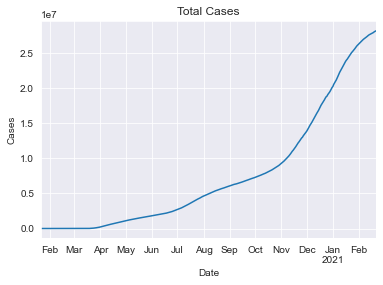

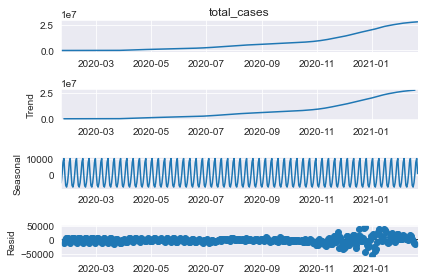

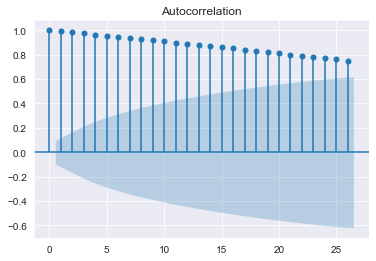

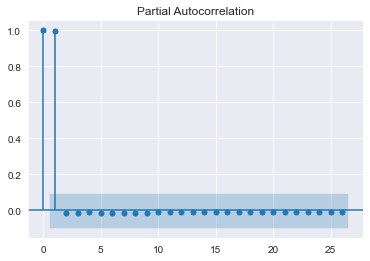

Adfuller results - p value: 0.7360694958188174


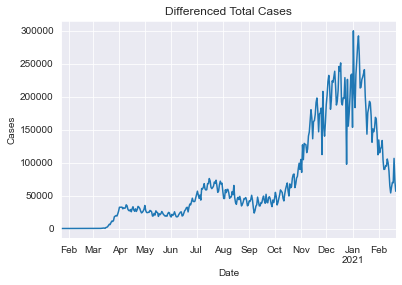

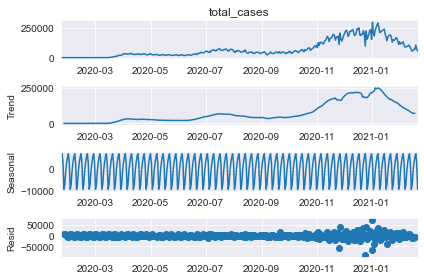

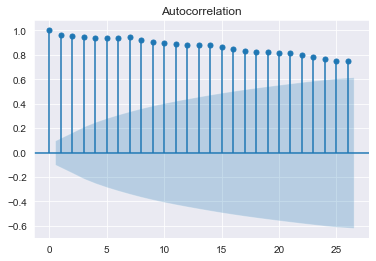

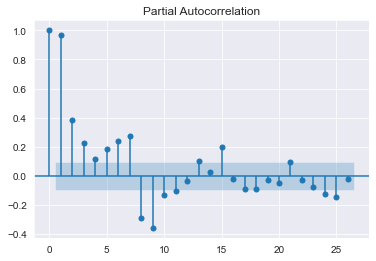

Differenced adfuller results - p value: 0.53765815648626


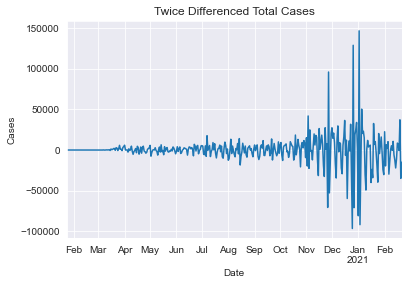

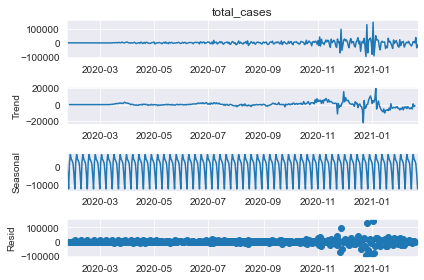

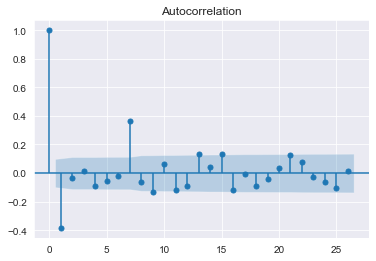

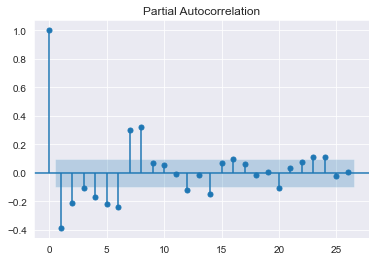

Twice-differenced adfuller results - p value: 0.00048821931169533385


In [21]:
run_diagnostics(us_data.total_cases, 'Total Cases', 'Cases')

In [22]:
tot_cases = us_data.total_cases
diff_tot_cases = us_data.total_cases.diff().diff().dropna()

In [23]:
train = tot_cases[:-30]
test = tot_cases[-30:]

diff_train = diff_tot_cases[:-30]
diff_test = diff_tot_cases[-30:]

print('Length of training set: ', len(train))
print('Length of testing set: ', len(test))
print('Length of differenced training set: ', len(diff_train))
print('Length of differenced testing set: ', len(diff_test))

Length of training set:  367
Length of testing set:  30
Length of differenced training set:  365
Length of differenced testing set:  30


In [24]:
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7, freq='D').fit()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [25]:
yhat_estc = model.predict(367, 396)
plot_test_predictions(yhat_estc, train, test)

Root Mean Squared Error:  1077297.02


In [26]:
model = ExponentialSmoothing(tot_cases, trend='add', seasonal='add', seasonal_periods=7, freq='D').fit()

predictions_estc = model.predict(397, 426)
plot_forecast(predictions_estc, tot_cases)

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                  367
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -4058.738
Date:                Thu, 08 Apr 2021   AIC                           8121.475
Time:                        16:59:22   BIC                           8129.275
Sample:                    01-22-2020   HQIC                          8124.575
                         - 01-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6144      0.022    -28.525      0.000      -0.657      -0.572
sigma2       2.79e+08   1.05e-11   2.66e+19      0.000    2.79e+08    2.79e+08
Ljung-Box (L1) (Q):                   0.37   Jarque-

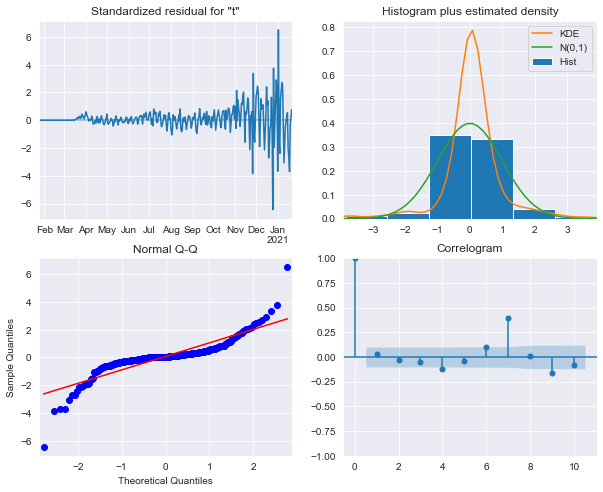

In [27]:
model = ARIMA(train, order=(0,2,1), enforce_stationarity=True, enforce_invertibility=True, freq='D')
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [28]:
yhat_arima_tc = results.predict(367, 396)
plot_test_predictions(yhat_arima_tc, train, test)

Root Mean Squared Error:  1172530.69


/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                  397
Model:                 ARIMA(8, 2, 1)   Log Likelihood               -4338.699
Date:                Thu, 08 Apr 2021   AIC                           8697.397
Time:                        16:59:27   BIC                           8737.186
Sample:                    01-22-2020   HQIC                          8713.162
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4046      0.137     -2.963      0.003      -0.672      -0.137
ar.L2         -0.1798      0.068     -2.646      0.008      -0.313      -0.047
ar.L3         -0.0718      0.071     -1.012      0.3

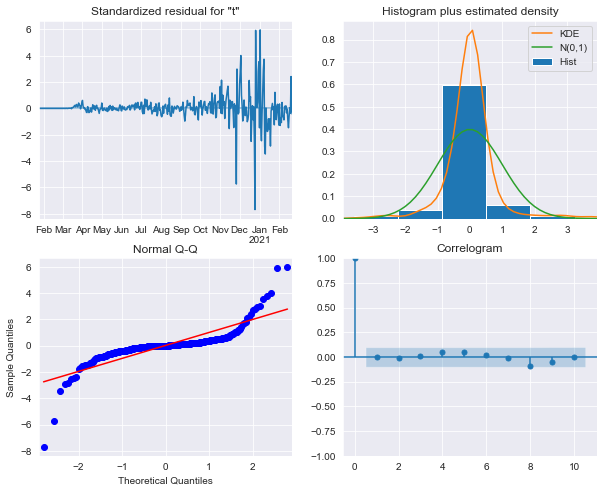

In [29]:
model = ARIMA(tot_cases, order=(8,2,1), enforce_stationarity=True, enforce_invertibility=True, freq='D')
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [30]:
prediction_arima_tc = results.forecast(30)
plot_forecast(prediction_arima_tc, tot_cases)

In [31]:
predictions_arima_tc = results.forecast(30)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_tc.index,
                         y=predictions_arima_tc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

In [32]:
auto_results_tc = auto_arima(train, m=7)
auto_results_tc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  367
Model:             SARIMAX(0, 2, 2)x(1, 0, 2, 7)   Log Likelihood               -4016.039
Date:                           Thu, 08 Apr 2021   AIC                           8044.079
Time:                                   17:00:09   BIC                           8067.478
Sample:                                        0   HQIC                          8053.378
                                           - 367                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6754      0.023    -29.420      0.000      -0.720      -0.630
ma.L2          0.1216      0.038      3.176      0.001       0.047       0.197
ar.S.L7        0.9778      0.034     28.868      0.000       0.911       1.044
ma.S.L7       -0.5375      0.050    -10.705      0.000      -0.636      -0.439
ma.S.L14      -0.3200      0.042     -7.696      0.000      -0.402      -0.239
sigma2      2.679e+08   7.26e-11   3.69e+18      0.000    2.68e+08    2.68e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9830.05
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             113.93   Skew:                            -1.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.1e+34. Standard errors may be unstable.
"""

In [33]:
yhat_auto_tc = auto_results_tc.predict(n_periods = 30)
plot_test_predictions(yhat_auto_tc, train, test)

Root Mean Squared Error:  920629.69


In [34]:
auto_results_tc.fit(tot_cases)
predictions_atc = auto_results_tc.predict(n_periods = 30)

In [35]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_tc.index,
                         y=predictions_atc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

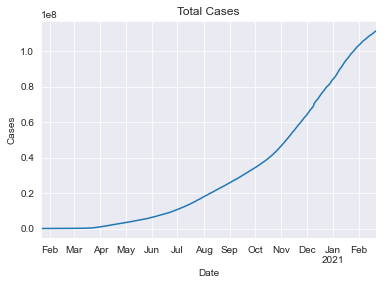

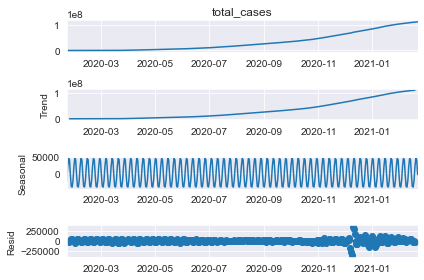

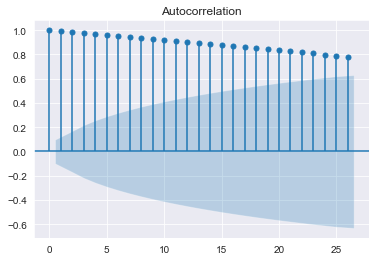

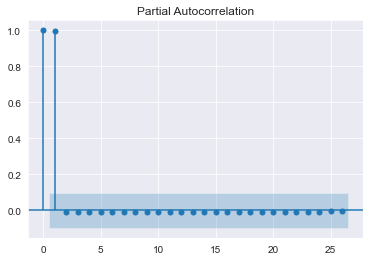

Adfuller results - p value: 0.6848217549827582


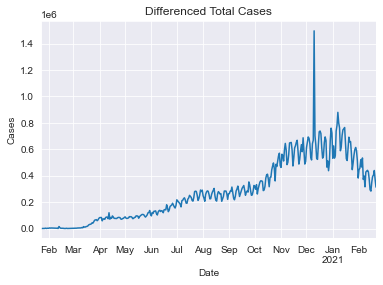

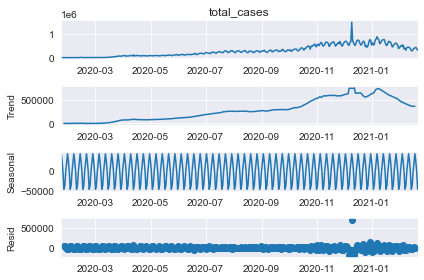

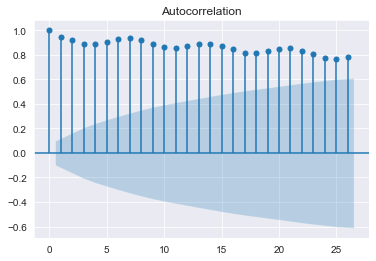

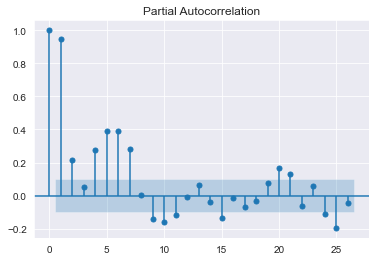

Differenced adfuller results - p value: 0.6250287551586439


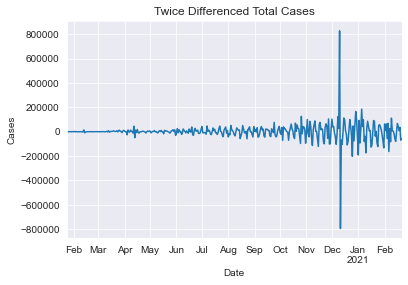

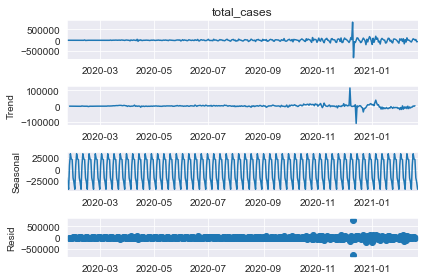

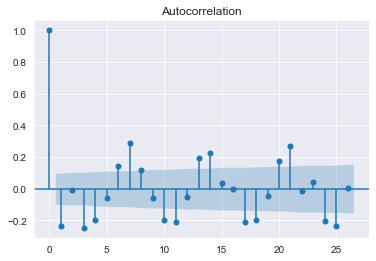

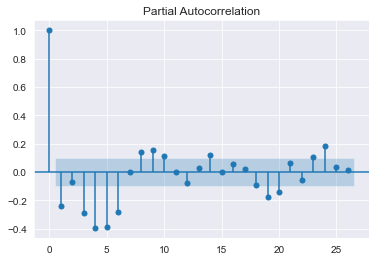

Twice-differenced adfuller results - p value: 7.527888213379484e-08


In [36]:
run_diagnostics(world_data.total_cases, 'Total Cases', 'Cases')

In [37]:
world_tot_cases = world_data.total_cases
diff_world_tot_cases = world_data.total_cases.diff().diff().dropna()

In [38]:
world_train = world_tot_cases[:-30]
world_test = world_tot_cases[-30:]

diff_world_train = diff_world_tot_cases[:-30]
diff_world_test = diff_world_tot_cases[-30:]

print('Length of training set: ', len(train))
print('Length of testing set: ', len(test))
print('Length of differenced training set: ', len(diff_train))
print('Length of differenced testing set: ', len(diff_test))

Length of training set:  367
Length of testing set:  30
Length of differenced training set:  365
Length of differenced testing set:  30


In [39]:
model = ExponentialSmoothing(world_train, trend='add', seasonal='add', seasonal_periods=7, freq='D').fit()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [40]:
yhat_eswtc = model.predict(365, 394)
plot_test_predictions(yhat_eswtc, world_train, world_test)
rmse = sqrt(mean_squared_error(yhat_eswtc, diff_world_test))

Root Mean Squared Error:  1816240.56


In [41]:
model = ExponentialSmoothing(world_tot_cases, trend='add', seasonal='add', seasonal_periods=7, freq='D').fit()

predictions_eswtc = model.predict(393, 423)
plot_forecast(predictions_eswtc, world_tot_cases)

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                  367
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -4565.507
Date:                Thu, 08 Apr 2021   AIC                           9137.015
Time:                        17:00:25   BIC                           9148.714
Sample:                    01-22-2020   HQIC                          9141.664
                         - 01-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3544      0.041      8.613      0.000       0.274       0.435
ma.L1         -0.8719      0.035    -25.272      0.000      -0.940      -0.804
sigma2      5.067e+09    6.6e-12   7.68e+20      0.0

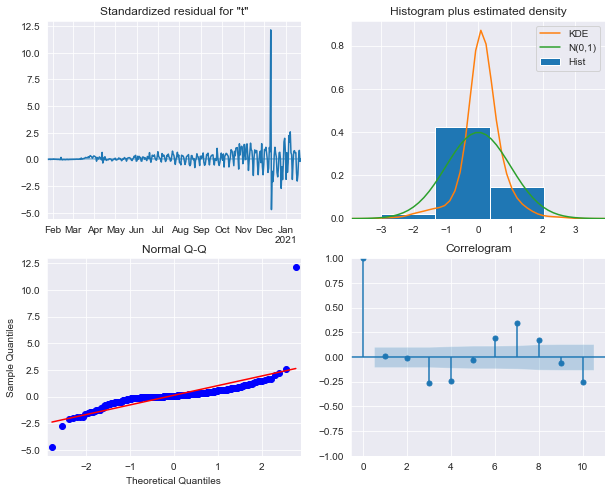

In [42]:
model = ARIMA(world_train, order=(1,2,1), enforce_stationarity=True, enforce_invertibility=True, freq='D')
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [43]:
yhat_arima_wtc = results.predict(365, 394)
plot_test_predictions(yhat_arima_wtc, world_train, world_test)

Root Mean Squared Error:  2415435.26


/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                  397
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -4944.363
Date:                Thu, 08 Apr 2021   AIC                           9894.726
Time:                        17:00:28   BIC                           9906.663
Sample:                    01-22-2020   HQIC                          9899.455
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3675      0.044      8.291      0.000       0.281       0.454
ma.L1         -0.8477      0.039    -21.508      0.000      -0.925      -0.770
sigma2      5.084e+09   3.92e-12    1.3e+21      0.0

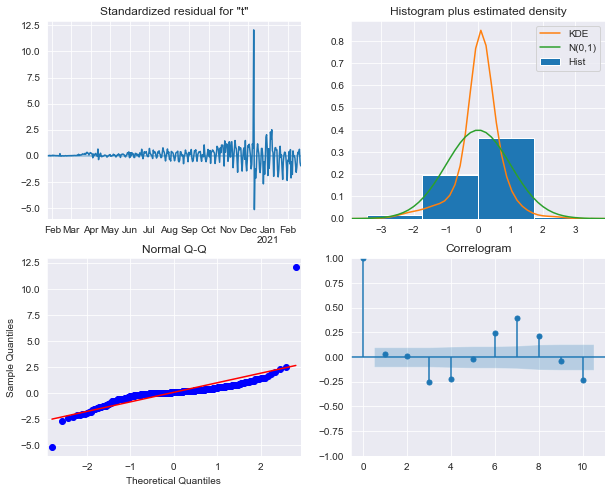

In [44]:
model = ARIMA(world_tot_cases, order=(1,2,1), enforce_stationarity=True, enforce_invertibility=True, freq='D')
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [45]:
predictions_arima_wtc = results.forecast(30)
plot_forecast(predictions_arima_wtc, world_tot_cases)

In [46]:
auto_results_wtc = auto_arima(world_train, m=7)
auto_results_wtc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  367
Model:             SARIMAX(3, 2, 3)x(2, 0, [], 7)   Log Likelihood               -4497.496
Date:                            Thu, 08 Apr 2021   AIC                           9012.992
Time:                                    17:02:50   BIC                           9048.091
Sample:                                         0   HQIC                          9026.941
                                            - 367                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1541      0.066     17.411      0.000       1.024       1.284
ar.L2         -0.8858      0.081    -10.945      0.000      -1.044      -0.727
ar.L3         -0.0890      0.062     -1.445      0.149      -0.210       0.032
ma.L1         -1.8924      0.063    -29.904      0.000      -2.016      -1.768
ma.L2          1.7231      0.098     17.635      0.000       1.532       1.915
ma.L3         -0.6014      0.065     -9.273      0.000      -0.729      -0.474
ar.S.L7        0.0807      0.041      1.952      0.051      -0.000       0.162
ar.S.L14      -0.1421      0.070     -2.044      0.041      -0.278      -0.006
sigma2      3.436e+09   1.57e-10   2.19e+19      0.000    3.44e+09    3.44e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):            239234.47
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):             126.84   Skew:                             8.12
Prob(H) (two-sided):                  0.00   Kurtosis:                       127.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+34. Standard errors may be unstable.
"""

In [47]:
yhat_auto_wtc = auto_results_wtc.predict(n_periods = 30)
plot_test_predictions(yhat_auto_wtc, world_train, world_test)

Root Mean Squared Error:  2405117.02


In [48]:
auto_results_wtc.fit(world_tot_cases)
predictions_awtc = auto_results_wtc.predict(n_periods = 30)

In [49]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=world_tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_wtc.index,
                         y=predictions_awtc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

In [50]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_data.index,
                         y=us_data.new_cases, 
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=us_data.index,
                         y=us_data.new_cases_smoothed,
                         mode='lines',
                         name='New Cases Smoothed'))


fig.show()

In [51]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.new_cases, 
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.new_cases_smoothed,
                         mode='lines',
                         name='New Cases Smoothed'))


fig.show()

In [52]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_data.index,
                         y=us_data.new_cases_per_million, 
                         mode = 'lines', 
                         name='New Cases Per Million'))
fig.add_trace(go.Scatter(x=us_data.index,
                         y=us_data.new_cases_smoothed_per_million,
                         mode='lines',
                         name='New Cases Smoothed Per Million'))


fig.show()

In [53]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.new_cases_per_million, 
                         mode = 'lines', 
                         name='New Cases Per Million'))
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.new_cases_smoothed_per_million,
                         mode='lines',
                         name='New Cases Smoothed Per Million'))


fig.show()

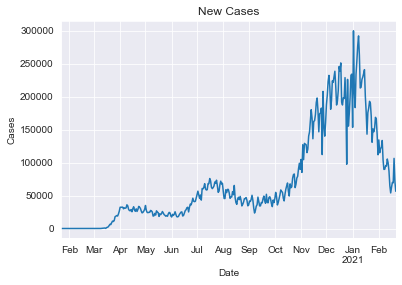

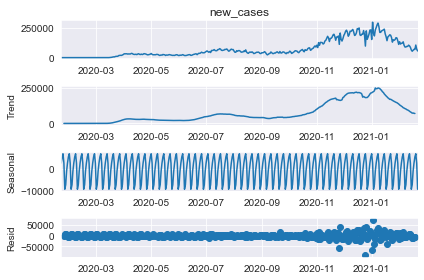

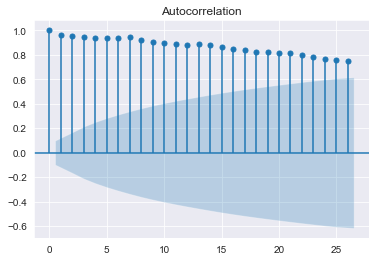

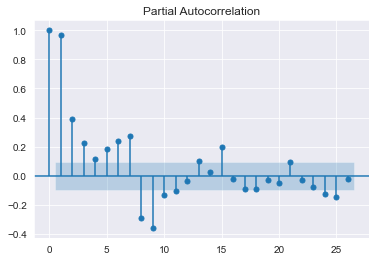

Adfuller results - p value: 0.5382638138932434


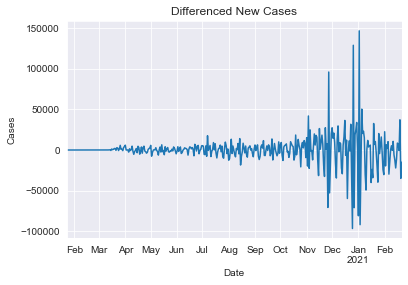

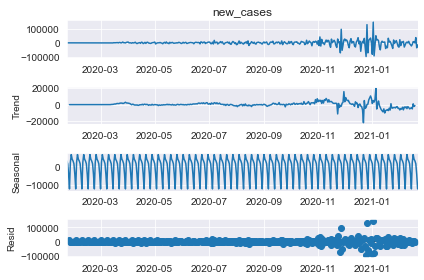

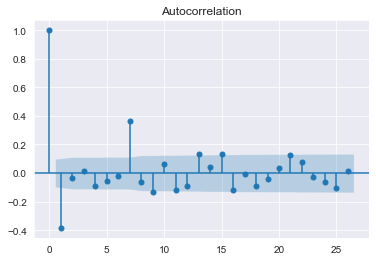

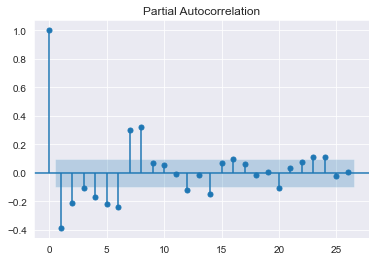

Differenced adfuller results - p value: 0.00047699988275942565


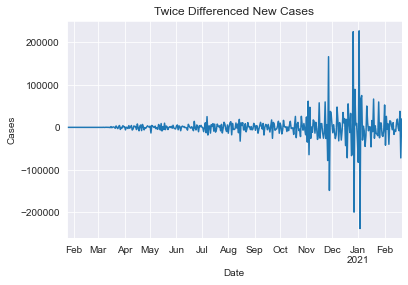

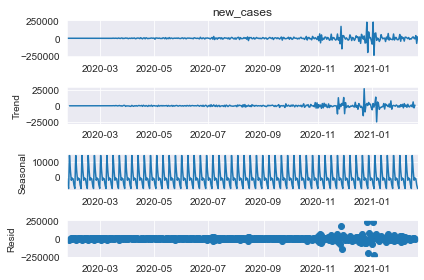

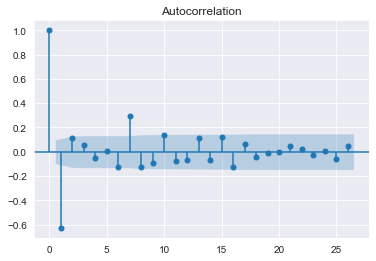

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



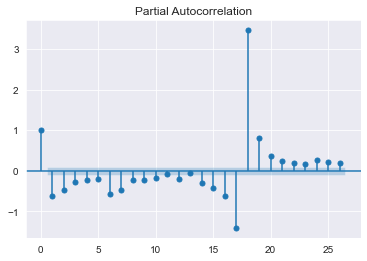

Twice-differenced adfuller results - p value: 1.929058663199112e-14


In [54]:
run_diagnostics(us_data.new_cases, 'New Cases', 'Cases')

In [55]:
new_cases = us_data.new_cases
diff_new_cases = us_data.new_cases.diff().dropna()

In [56]:
train_nc = new_cases[:-30]
test_nc = new_cases[-30:]

diff_train_nc = diff_new_cases[:-30]
diff_test_nc = diff_new_cases[-30:]

print('Length of training set: ', len(train_nc))
print('Length of testing set: ', len(test_nc))
print('Length of differenced training set: ', len(diff_train_nc))
print('Length of differenced testing set: ', len(diff_test_nc))

Length of training set:  367
Length of testing set:  30
Length of differenced training set:  366
Length of differenced testing set:  30


In [57]:
model = ExponentialSmoothing(train_nc, trend='add', seasonal='add', seasonal_periods=7, freq='D').fit()
yhat_hwnc = model.predict(366, 395)
plot_test_predictions(yhat_hwnc, train_nc, test_nc)

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation



Root Mean Squared Error:  80133.95


/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [58]:
'''print('Root Mean Squared Error: ', round(rmse, 2))

fig = go.Figure()
fig.add_trace(go.Scatter(x=new_cases.index,
                         y=new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=diff_test_nc.index,
                         y=yhat_hwnc,
                         mode='lines',
                         name='Predicted New Cases'))


fig.show()'''

"print('Root Mean Squared Error: ', round(rmse, 2))\n\nfig = go.Figure()\nfig.add_trace(go.Scatter(x=new_cases.index,\n                         y=new_cases,\n                         mode = 'lines', \n                         name='New Cases'))\nfig.add_trace(go.Scatter(x=diff_test_nc.index,\n                         y=yhat_hwnc,\n                         mode='lines',\n                         name='Predicted New Cases'))\n\n\nfig.show()"

In [59]:
model = ExponentialSmoothing(new_cases, trend='add', seasonal='add', seasonal_periods=7, freq='D').fit()
predictions_hwnc = model.predict(395, 425)
plot_forecast(predictions_hwnc, new_cases)

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  367
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -4068.625
Date:                Thu, 08 Apr 2021   AIC                           8143.250
Time:                        17:03:09   BIC                           8154.958
Sample:                    01-22-2020   HQIC                          8147.902
                         - 01-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5766      0.021    -27.276      0.000      -0.618      -0.535
ma.L2         -0.0529      0.022     -2.354      0.019      -0.097      -0.009
sigma2      2.671e+08   3.11e-11   8.59e+18      0.0

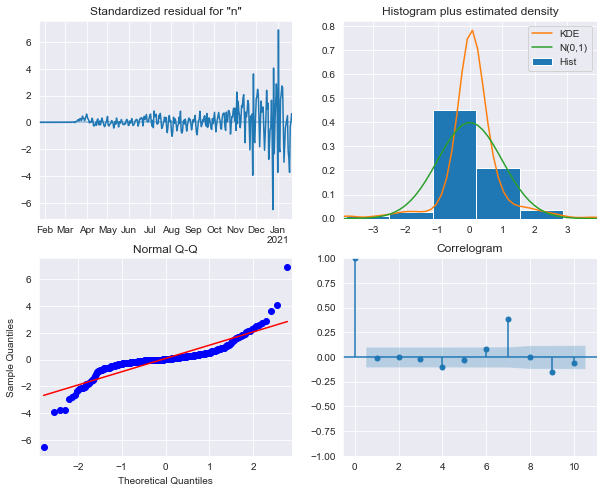

In [60]:
model = ARIMA(train_nc, order=(0,1,2), enforce_stationarity=True, enforce_invertibility=True, freq='D')
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [61]:
yhat_arima_nc = results.forecast(30)
plot_test_predictions(yhat_arima_nc, train_nc, test_nc)

Root Mean Squared Error:  84993.29


/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  397
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -4408.747
Date:                Thu, 08 Apr 2021   AIC                           8823.494
Time:                        17:03:12   BIC                           8835.438
Sample:                    01-22-2020   HQIC                          8828.226
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5325      0.021    -25.696      0.000      -0.573      -0.492
ma.L2         -0.0642      0.023     -2.812      0.005      -0.109      -0.019
sigma2      2.731e+08   2.88e-11   9.47e+18      0.0

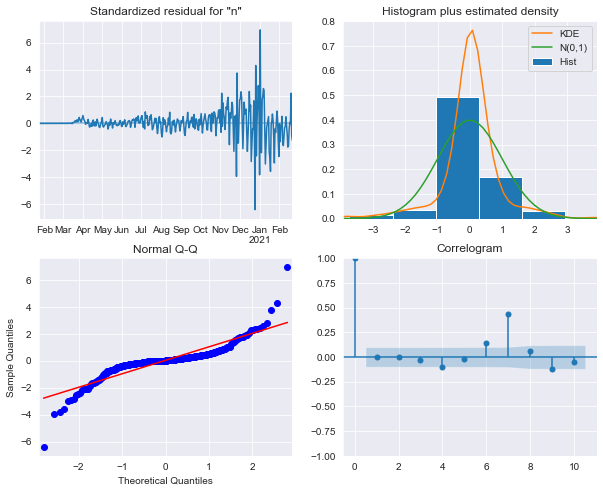

In [62]:
model = ARIMA(new_cases, order=(0,1,2), enforce_stationarity=True, enforce_invertibility=True, freq='D')
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [63]:
predictions_arima_nc = results.forecast(30)
plot_forecast(predictions_arima_nc, new_cases)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_tc.index,
                         y=predictions_arima_nc,
                         mode='lines',
                         name='Predicted New Cases'))

fig.show()

In [64]:
auto_results_nc = auto_arima(train_nc, m=7)
auto_results_nc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  367
Model:             SARIMAX(0, 1, 2)x(1, 0, 2, 7)   Log Likelihood               -4026.761
Date:                           Thu, 08 Apr 2021   AIC                           8065.522
Time:                                   17:03:54   BIC                           8088.938
Sample:                                        0   HQIC                          8074.827
                                           - 367                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6740      0.023    -29.453      0.000      -0.719      -0.629
ma.L2          0.1203      0.038      3.154      0.002       0.046       0.195
ar.S.L7        0.9771      0.034     28.427      0.000       0.910       1.044
ma.S.L7       -0.5384      0.051    -10.642      0.000      -0.638      -0.439
ma.S.L14      -0.3200      0.042     -7.671      0.000      -0.402      -0.238
sigma2      2.671e+08   7.56e-11   3.53e+18      0.000    2.67e+08    2.67e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9833.39
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             113.90   Skew:                            -1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.13e+33. Standard errors may be unstable.
"""

In [65]:
yhat_auto_nc = auto_results_nc.predict(n_periods = 30)
plot_test_predictions(yhat_auto_nc, train_nc, test_nc)
rmse = sqrt(mean_squared_error(yhat_auto_nc, test_nc))
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()

fig.add_trace(go.Scatter(x = us_data.index,
                         y = new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=yhat_arima_nc.index,
                         y=yhat_auto_nc,
                         mode='lines',
                         name='Predicted New Cases'))

fig.show()

Root Mean Squared Error:  72882.46


Root Mean Squared Error:  72882.45900901828


In [66]:
auto_results_nc.fit(new_cases)
predictions_anc = auto_results_nc.predict(30)

In [67]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = us_data.index,
                         y = new_cases,
                         mode = 'lines', 
                         name='Differenced New Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_nc.index,
                         y=predictions_anc,
                         mode='lines',
                         name='Predicted Differenced New Cases'))

fig.show()

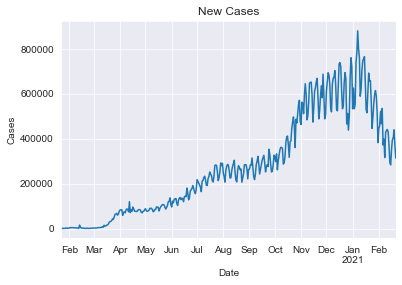

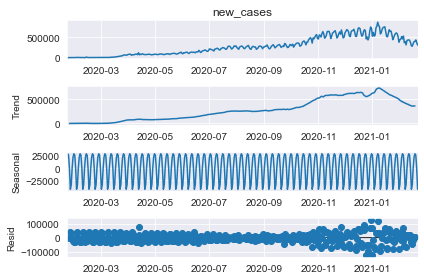

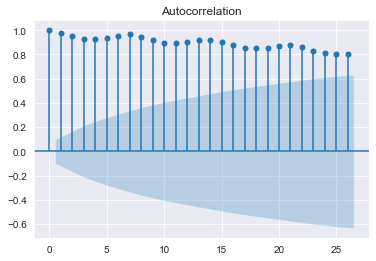

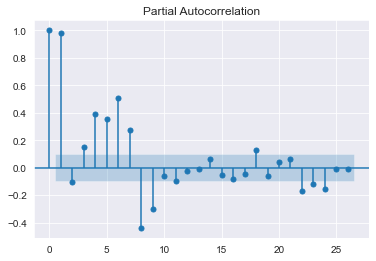

Adfuller results - p value: 0.6031794952887767


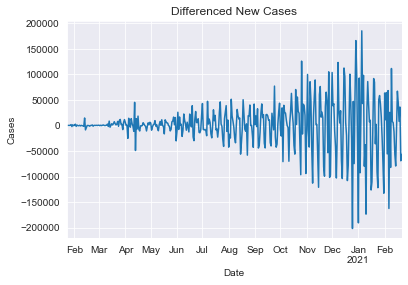

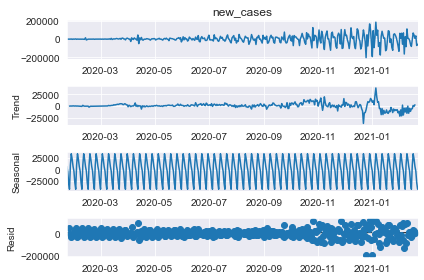

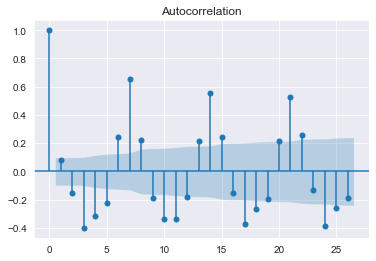

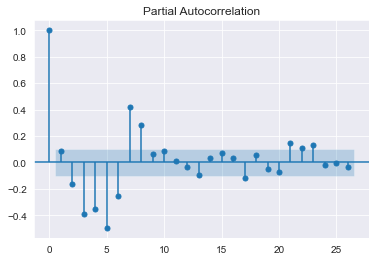

Differenced adfuller results - p value: 7.01569031732402e-05


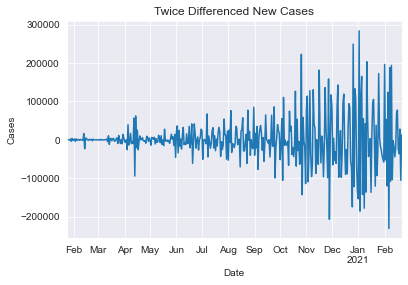

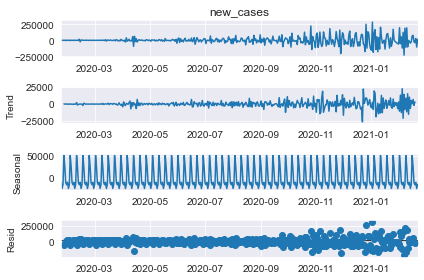

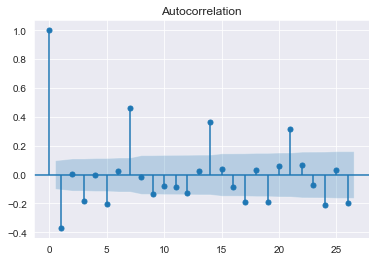

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



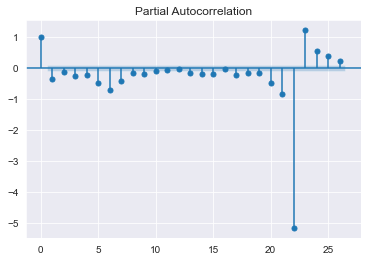

Twice-differenced adfuller results - p value: 1.3304576108420565e-11


In [68]:
run_diagnostics(world_data.new_cases, 'New Cases', 'Cases')

In [69]:
world_new_cases = world_data.new_cases
diff_world_new_cases = world_data.new_cases.diff().dropna()

In [70]:
world_train_nc = world_new_cases[:-30]
world_test_nc = world_new_cases[-30:]

diff_world_train_nc = diff_world_new_cases[:-30]
diff_world_test_nc = diff_world_new_cases[-30:]

print('Length of training set: ', len(world_train_nc))
print('Length of testing set: ', len(world_test_nc))
print('Length of differenced training set: ', len(diff_world_train_nc))
print('Length of differenced testing set: ', len(diff_world_test_nc))

Length of training set:  367
Length of testing set:  30
Length of differenced training set:  366
Length of differenced testing set:  30


In [71]:
model = ExponentialSmoothing(world_train_nc, seasonal_periods=7, freq='D').fit()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [72]:
yhat_eswnc = model.predict(365, 394)
plot_test_predictions(yhat_eswnc, world_train_nc, world_test_nc)

Root Mean Squared Error:  235501.29


In [73]:
model = ExponentialSmoothing(world_new_cases, seasonal_periods=7, freq='D').fit()
predictions_eswnc = model.predict(393, 423)
plot_forecast(predictions_eswnc, world_new_cases)

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  367
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4318.401
Date:                Thu, 08 Apr 2021   AIC                           8646.802
Time:                        17:04:13   BIC                           8666.315
Sample:                    01-22-2020   HQIC                          8654.556
                         - 01-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2172      0.020     60.106      0.000       1.178       1.257
ar.L2         -0.8966      0.017    -52.007      0.000      -0.930      -0.863
ma.L1         -1.4565      0.024    -60.509      0.0

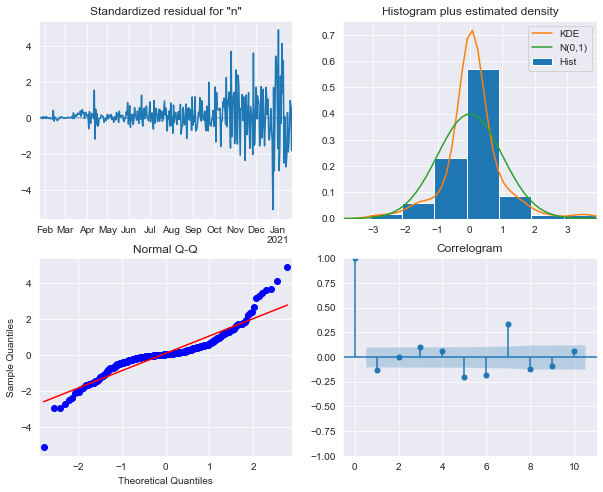

In [74]:
model = ARIMA(world_train_nc, order=(2,1,2), enforce_stationarity=True, enforce_invertibility=True, freq='D')
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [75]:
yhat_arima_wnc = results.predict(365, 394)
plot_test_predictions(yhat_arima_wnc, world_train_nc, world_test_nc)

Root Mean Squared Error:  201347.21


/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  397
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4695.310
Date:                Thu, 08 Apr 2021   AIC                           9400.619
Time:                        17:04:19   BIC                           9420.526
Sample:                    01-22-2020   HQIC                          9408.506
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2106      0.022     55.294      0.000       1.168       1.253
ar.L2         -0.8986      0.019    -47.344      0.000      -0.936      -0.861
ma.L1         -1.4440      0.026    -56.580      0.0

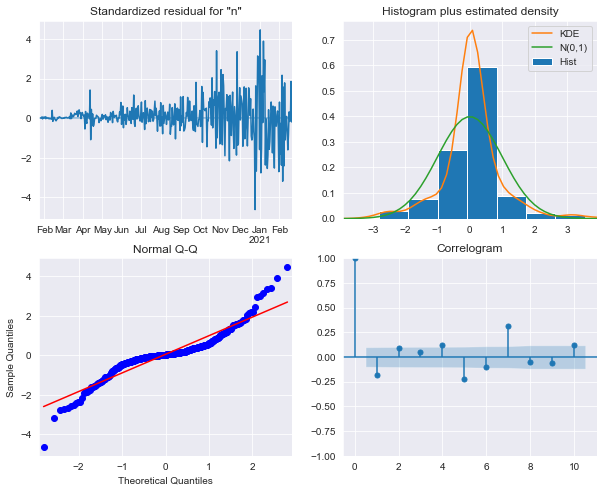

In [76]:
model = ARIMA(world_new_cases, order=(2,1,2), enforce_stationarity=True, enforce_invertibility=True, freq='D')
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [77]:
predictions_arima_wnc = results.predict(394, 424)
plot_forecast(predictions_arima_wnc, world_new_cases)

In [78]:
auto_results_wnc = auto_arima(world_train_nc, m=7)
auto_results_wnc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  367
Model:             SARIMAX(5, 1, 0)x(1, 0, [1, 2], 7)   Log Likelihood               -4274.428
Date:                                Thu, 08 Apr 2021   AIC                           8566.856
Time:                                        17:05:59   BIC                           8601.980
Sample:                                             0   HQIC                          8580.813
                                                - 367                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3706      0.051     -7.335      0.000      -0.470      -0.272
ar.L2         -0.2814      0.056     -5.006      0.000      -0.392      -0.171
ar.L3         -0.2674      0.054     -4.941      0.000      -0.373      -0.161
ar.L4         -0.1684      0.047     -3.571      0.000      -0.261      -0.076
ar.L5         -0.1468      0.045     -3.298      0.001      -0.234      -0.060
ar.S.L7        0.9731      0.025     38.368      0.000       0.923       1.023
ma.S.L7       -0.4805      0.053     -9.041      0.000      -0.585      -0.376
ma.S.L14      -0.2484      0.058     -4.253      0.000      -0.363      -0.134
sigma2      1.079e+09   3.68e-11   2.93e+19      0.000    1.08e+09    1.08e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2132.25
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              34.67   Skew:                            -0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.16e+33. Standard errors may be unstable.
"""

In [79]:
yhat_auto_wnc = auto_results_wnc.predict(n_periods = 30)
plot_test_predictions(yhat_auto_wnc, world_train_nc, world_test_nc)

Root Mean Squared Error:  150640.92


In [80]:
auto_results_wnc.fit(world_new_cases)
predictions_awnc = auto_results_wnc.predict(n_periods = 30)

In [81]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=world_new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_wnc.index,
                         y=predictions_awnc,
                         mode='lines',
                         name='Predicted New Cases'))

fig.show()